## Imports

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import json

import torchvision
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_auc_score
from PIL import Image
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler

import torch
import torchvision.models as models
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import ResNet50_Weights

from torch.utils.tensorboard import SummaryWriter


In [2]:
# label definitions
ALLERGENS = [
    "Cereals containing gluten", "Crustaceans", "Eggs", "Fish",
    "Peanuts", "Soybeans", "Milk", "Nuts", "Celery", "Mustard",
    "Sesame seeds",  "Sulphur dioxide and sulphites", "Lupin", "Molluscs"
]

## Store Dataset Paths

In [3]:
dataset_directory = "../Dataset Generation/dataset"

# Image and label directory arrays
images = []
labels = []

for recipe_folder in os.listdir(dataset_directory):
    recipe_path = os.path.join(dataset_directory, recipe_folder)
    allergens_file = os.path.join(recipe_path, 'allergens.json')

    if os.path.isfile(allergens_file):
        with open(allergens_file, 'r') as f:
            data = json.load(f)
            allergens = data['allergens']

            for image in data['images']:
                images.append(os.path.join(dataset_directory, recipe_folder, image))
                labels.append(allergens)

x = np.array(images).reshape(-1,1) # iterative_train_test_split expects 2d array
y = np.array(labels)

## Dataset Class

In [4]:
# Dataset class shell: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files

class FoodAllergenDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, target_transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx][0]
        image = Image.open(img_path).convert('RGB') # Convert all images to 3 channel RGB as dataset contains some 4 channel RGBA images
        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

## EarlyStopping

In [5]:
"""
https://www.geeksforgeeks.org/how-to-handle-overfitting-in-pytorch-models-using-early-stopping/

patience: Number of epochs to wait before stopping if no improvement.
delta: Minimum change in the monitored quantity to qualify as an improvement.
best_score, best_model_state: Track the best validation score and model state.
call method: Updates the early stopping logic.
"""

class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

## Model Saving

In [6]:
# https://pytorch.org/tutorials/beginner/saving_loading_models.html
def save_model(epoch, model, optimizer, training_losses, validation_losses, filename):
    torch.save({
        "epoch": epoch+1,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "training_losses": training_losses, # full loss history, so that post-checkpoint models will have correct loss graph
        "validation_losses": validation_losses
    }, filename)

## LeNet model

In [7]:
# https://pytorch.org/tutorials/beginner/introyt/trainingyt.html
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

## Training Function

In [8]:
# https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html
def train_one_epoch(dataloader, model, loss_fn, optimizer, device, writer):
    size = len(dataloader.dataset)
    model.train()
    total_loss = 0.0

    for batch, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)
        prediction = model(images)
        loss = loss_fn(prediction, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        # Accumulate loss for this batch
        total_loss += loss.item()

        # image grid for tensorboard - makes file size too big for github
        # img_grid = torchvision.utils.make_grid(images)
        # writer.add_image('Training_Images', img_grid, global_step=batch)

        # if batch % 100 == 0:
        #     current = batch * len(images)
        #     print(f"Loss: {loss.item():.7f} [{current:5d}/{size:5d}]")

    avg_train_loss = total_loss / len(dataloader)
    #print(f"Train loss for this epoch: {avg_train_loss:.7f}")

    # Return average training loss for this epoch
    return avg_train_loss

## Validation Function

In [9]:
def validate_one_epoch(dataloader, model, loss_fn, device):
    model.eval()
    running_val_loss = 0.0
    running_correct = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs)
            preds = (probs > hyperparameters['prediction_threshold'])
            loss = loss_fn(outputs, labels)
            running_val_loss += loss.item()
            running_correct += (preds == labels).sum().item()

    val_loss = running_val_loss / len(dataloader)
    val_accuracy = 100 * running_correct / len(dataloader.dataset)
    #print(f"Validation loss for this epoch: {val_loss:.7f}")

    # Return average validation loss for this epoch
    return val_loss, val_accuracy

## Testing Function

In [10]:
# https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

def test_loop(dataloader, model, hyperparameters, device, label, writer):
    model.eval()
    total, correct = 0, 0
    all_predictions = []
    all_actual = []
    all_probabilities = []

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputLogits = model(images)
            probs = torch.sigmoid(outputLogits) # Apply sigmoid to convert logits to get probabilities 0-1
            preds = (probs > hyperparameters['prediction_threshold']) # Get binary predictions based on prediction threshold param

            total += labels.numel()
            correct += (preds == labels).sum().item()

            all_probabilities.append(probs.cpu().numpy())
            all_predictions.append(preds.cpu().numpy())
            all_actual.append(labels.cpu().numpy())

    all_probabilities = np.concatenate(all_probabilities, axis=0)
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_actual = np.concatenate(all_actual, axis=0)

    accuracy = 100 * correct / total
    # print(f'Test Error: \n Accuracy: {accuracy:.2f} % \n\n')

    writer.add_scalar('Test_Accuracy For Best Model State (lowest val loss)', accuracy)
    writer.add_pr_curve('Test_Precision_Recall_Curve For Best Model State (lowest val loss)', all_actual, all_probabilities, global_step=0)

    matrix = confusion_matrix(all_actual, all_predictions)
    matrix_figure = plt.figure(figsize=(4, 3))
    sns.heatmap(
        matrix,
        annot=True,
        fmt="d",
        cmap="Reds",
        cbar=False,
        xticklabels=["Pred Negative", "Pred Positive"],
        yticklabels=["True Negative", "True Positive"]
    )
    plt.title(f"Confusion Matrix: {ALLERGENS[label]}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    # plt.show()
    writer.add_figure('Confusion_Matrix on Test Set For Best Model State (lowest val loss)', matrix_figure)

    #print("\n\nClassification Report:")
    # Sklearn classification report
    report = classification_report(all_actual, all_predictions)
    # print(report)
    writer.add_text('Classification Report', report)

## Train Single Allergen Label Function

In [11]:
def train_for_allergen_label(label, x, y, hyperparameters):
    y = y[:, label] # get label values for specific allergen label

    # positives = np.sum(y==1)
    # negatives = np.sum(y==0)
    # print(f"Before resampling: {positives} positives, {negatives} negatives")

    resampler = RandomUnderSampler() # create random under sampler from unbalanced-learn library
    x_balanced, y_balanced = resampler.fit_resample(x, y) # balance x and y
    y_balanced = y_balanced.reshape(-1,1) # iterative_train_test_split expects 2d array

    # positives = np.sum(y_balanced==1)
    # negatives = np.sum(y_balanced==0)
    # print(f"After resampling: {positives} positives, {negatives} negatives\n")

    x_train, y_train, x_test, y_test = iterative_train_test_split(x_balanced, y_balanced, 0.3) # train test split

    # Transform images to tensors and resize
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=15),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    val_test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    # Test more transforms later in training to improve accuracy - cropping, rotation, centering, flipping etc.

    # Initialise datasets
    train_dataset = FoodAllergenDataset(x_train, y_train, transform=transform)
    val_dataset = FoodAllergenDataset(x_test, y_test, transform=val_test_transform)
    test_dataset = FoodAllergenDataset(x_test, y_test, transform=val_test_transform)

    # Create Train Test Val DataLoaders
    train_dataloader = DataLoader(train_dataset, batch_size=hyperparameters['batch_size'], shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=hyperparameters['batch_size'], shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=hyperparameters['batch_size'], shuffle=False)

    # set accelerator device cpu/gpu
    device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
    #print(f"Using {device} device")

    # Define model - ResNet50
    model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
    model.fc = nn.Linear(model.fc.in_features, 1) # altered final layer for single output binary classification
    # model = Net()
    model = model.to(device)
    batch_size = hyperparameters['batch_size']
    learning_rate = hyperparameters['learning_rate']
    # Tensorboard writer
    writer = SummaryWriter(f'runs/{ALLERGENS[label]}/{model._get_name()}/BatchSize {batch_size} LR {learning_rate}') # change run name for every run
    # track hyperparameters on tensorboard
    writer.add_hparams(hyperparameters,{})

    example_input = torch.rand(1, 3, 224, 224).to(device) # add_graph requires sample data for the model
    writer.add_graph(model, example_input) # add model architecture to tensorboard

    # log transforms
    for n, transform in enumerate(transform.transforms):
        writer.add_text(f'Transforms/Transform_{n}', str(transform))

    # Loss function and optimizer
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=hyperparameters['learning_rate'])

    epochs = hyperparameters['epochs']
    best_val_loss = 1_000_000.
    best_epoch = 0
    training_losses = []
    validation_losses = []
    early_stopping = EarlyStopping(hyperparameters['patience'], hyperparameters['delta'])

    # filename for saving the model
    filename = f"saved_models/{ALLERGENS[label]}/{model._get_name()}/BatchSize {batch_size}/LR {learning_rate}/{ALLERGENS[label]}.pt"
    os.makedirs(os.path.dirname(filename), exist_ok=True)

    for epoch in range(epochs):
        #print(f"\nEpoch {epoch+1}/{epochs}")

        # Train and validate this epoch
        train_loss = train_one_epoch(train_dataloader, model, loss_fn, optimizer, device, writer)
        val_loss, val_accuracy = validate_one_epoch(val_dataloader, model, loss_fn, device)

        # add loss scalars for tensorboard
        writer.add_scalar('Training_Loss', train_loss, epoch)
        writer.add_scalar('Validation_Loss', val_loss, epoch)
        writer.add_scalar('Validation_Accuracy', val_accuracy, epoch)

        # Append losses for this epoch
        training_losses.append(train_loss)
        validation_losses.append(val_loss)

        # Save best model if validation loss improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # save_model(epoch, model, optimizer, training_losses, validation_losses, filename) # Save best model as checkpoint (larger file), so that training can be resumed
            torch.save(model, filename) # Save best model
            best_epoch = epoch + 1
            #print(f"Saved new best model: {filename}")

        early_stopping(val_loss)
        if early_stopping.early_stop:
            #print("Early stopping\n")
            break
    #print(f"Training Complete\n")

    # load the best model before running test loop
    model = torch.load(filename, map_location=device, weights_only=False)

    #Plot train and val losses
    # plt.figure(figsize=(8, 6))
    # plt.plot(range(1, len(training_losses) + 1), training_losses, label='Training Loss')
    # plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.title('Training and Validation Loss for Allergen Label: ' + ALLERGENS[label])
    # plt.axvline(x=best_epoch, linestyle='--', label=f'Best Model (Epoch {best_epoch})')
    # plt.legend()
    # plt.grid(True)
    # plt.show()

    #print("TEST RESULTS FOR BEST MODEL (lowest val loss):\n\n")
    # Run test loop. Produces Confusion matrix + classification report. pass in writer for tensorboard
    test_loop(test_dataloader, model, hyperparameters, device, label, writer)

    # close tensorboard writer
    writer.close()

## Training Loop

In [12]:
allergen = 0 # gluten
# batch_sizes = [64, 128, 256]
# learning_rates = [0.01,0.001, 0.0001]
batch_sizes = [64]
learning_rates = [0.0001]
max_epochs = 100
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        hyperparameters = {
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'epochs': max_epochs,
            'patience': 5,
            'delta': 0,
            'prediction_threshold': 0.5,
        }
        train_for_allergen_label(allergen, x, y, hyperparameters)

C:\GitHub\FYP\.venv\Lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [13]:
# tune with different hyperparameter combinations
allergen = 1 # Crustaceans
# batch_sizes = [16, 32, 64]
# learning_rates = [0.01,0.001, 0.0001]
batch_sizes = [16]
learning_rates = [0.0001]
max_epochs = 100
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        hyperparameters = {
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'epochs': max_epochs,
            'patience': 5,
            'delta': 0,
            'prediction_threshold': 0.5,
        }
        train_for_allergen_label(allergen, x, y, hyperparameters)

In [14]:
# tune with different hyperparameter combinations
allergen = 2 # eggs
# batch_sizes = [64, 128, 256]
# learning_rates = [0.01,0.001, 0.0001]
batch_sizes = [128]
learning_rates = [0.0001]
max_epochs = 100
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        hyperparameters = {
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'epochs': max_epochs,
            'patience': 5,
            'delta': 0,
            'prediction_threshold': 0.5,
        }
        train_for_allergen_label(allergen, x, y, hyperparameters)

In [15]:
# tune with different hyperparameter combinations
allergen = 3 # fish
# batch_sizes = [32, 64, 128]
# learning_rates = [0.01,0.001, 0.0001]
batch_sizes = [32]
learning_rates = [0.0001]
max_epochs = 100
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        hyperparameters = {
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'epochs': max_epochs,
            'patience': 5,
            'delta': 0,
            'prediction_threshold': 0.5,
        }
        train_for_allergen_label(allergen, x, y, hyperparameters)

In [16]:
# tune with different hyperparameter combinations
allergen = 4 # Peanuts
# batch_sizes = [16, 32, 64]
# learning_rates = [0.01,0.001, 0.0001]
batch_sizes = [16]
learning_rates = [0.0001]
max_epochs = 100
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        hyperparameters = {
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'epochs': max_epochs,
            'patience': 5,
            'delta': 0,
            'prediction_threshold': 0.5,
        }
        train_for_allergen_label(allergen, x, y, hyperparameters)

In [17]:
# tune with different hyperparameter combinations
allergen = 5 # soybeans
# batch_sizes = [16, 32, 64]
# learning_rates = [0.01,0.001, 0.0001]
batch_sizes = [64]
learning_rates = [0.0001]
max_epochs = 100
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        hyperparameters = {
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'epochs': max_epochs,
            'patience': 5,
            'delta': 0,
            'prediction_threshold': 0.5,
        }
        train_for_allergen_label(allergen, x, y, hyperparameters)

In [18]:
# tune with different hyperparameter combinations
allergen = 6 # Milk
# batch_sizes = [32, 64, 128]
# learning_rates = [0.01,0.001, 0.0001]
batch_sizes = [32]
learning_rates = [0.0001]
max_epochs = 100
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        hyperparameters = {
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'epochs': max_epochs,
            'patience': 5,
            'delta': 0,
            'prediction_threshold': 0.5,
        }
        train_for_allergen_label(allergen, x, y, hyperparameters)

In [19]:
# tune with different hyperparameter combinations
allergen = 7 # Nuts
# batch_sizes = [32, 64, 128]
# learning_rates = [0.01,0.001, 0.0001]
batch_sizes = [64]
learning_rates = [0.0001]
max_epochs = 100
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        hyperparameters = {
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'epochs': max_epochs,
            'patience': 5,
            'delta': 0,
            'prediction_threshold': 0.5,
        }
        train_for_allergen_label(allergen, x, y, hyperparameters)

C:\GitHub\FYP\.venv\Lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [20]:
# tune with different hyperparameter combinations
allergen = 8 # Celery
# batch_sizes = [16, 32, 64]
# learning_rates = [0.01,0.001, 0.0001]
batch_sizes = [16]
learning_rates = [0.01,0.0001]
max_epochs = 100
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        hyperparameters = {
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'epochs': max_epochs,
            'patience': 5,
            'delta': 0,
            'prediction_threshold': 0.5,
        }
        train_for_allergen_label(allergen, x, y, hyperparameters)

C:\GitHub\FYP\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\GitHub\FYP\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\GitHub\FYP\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [21]:
# tune with different hyperparameter combinations
allergen = 9 # mustard
# batch_sizes = [32, 64, 128]
# learning_rates = [0.01,0.001, 0.0001]
batch_sizes = [32]
learning_rates = [0.001]
max_epochs = 100
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        hyperparameters = {
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'epochs': max_epochs,
            'patience': 5,
            'delta': 0,
            'prediction_threshold': 0.5,
        }
        train_for_allergen_label(allergen, x, y, hyperparameters)

In [22]:
# tune with different hyperparameter combinations
allergen = 10 # sesame
# batch_sizes = [16, 32, 64]
# learning_rates = [0.01,0.001, 0.0001]
batch_sizes = [16]
learning_rates = [0.0001]
max_epochs = 100
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        hyperparameters = {
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'epochs': max_epochs,
            'patience': 5,
            'delta': 0,
            'prediction_threshold': 0.5,
        }
        train_for_allergen_label(allergen, x, y, hyperparameters)

In [23]:
# tune with different hyperparameter combinations
allergen = 13 # molluscs
# batch_sizes = [16, 32, 64]
# learning_rates = [0.01,0.001, 0.0001]
batch_sizes = [16]
learning_rates = [0.0001]
max_epochs = 100
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        hyperparameters = {
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'epochs': max_epochs,
            'patience': 5,
            'delta': 0,
            'prediction_threshold': 0.5,
        }
        train_for_allergen_label(allergen, x, y, hyperparameters)

## Benchmarks

Before resampling: 2414 positives, 59608 negatives
After resampling: 2414 positives, 2414 negatives

Using cuda device

Epoch 1/20
Loss: 0.6935193 [    0/ 3862]
Loss: 0.6620920 [ 3200/ 3862]
Train loss for this epoch: 0.6495269
Validation loss for this epoch: 0.6773170
Saved new best model: Crustaceans.pt

Epoch 2/20
Loss: 0.5868307 [    0/ 3862]
Loss: 0.6296228 [ 3200/ 3862]
Train loss for this epoch: 0.6221534
Validation loss for this epoch: 0.6070781
Saved new best model: Crustaceans.pt

Epoch 3/20
Loss: 0.7097537 [    0/ 3862]
Loss: 0.6260682 [ 3200/ 3862]
Train loss for this epoch: 0.5875226
Validation loss for this epoch: 0.6787716

Epoch 4/20
Loss: 0.7126064 [    0/ 3862]
Loss: 0.6289352 [ 3200/ 3862]
Train loss for this epoch: 0.5699441
Validation loss for this epoch: 0.6345572

Epoch 5/20
Loss: 0.5693681 [    0/ 3862]
Loss: 0.4752606 [ 3200/ 3862]
Train loss for this epoch: 0.5482071
Validation loss for this epoch: 0.5947724
Saved new best model: Crustaceans.pt

Epoch 6/20
Los

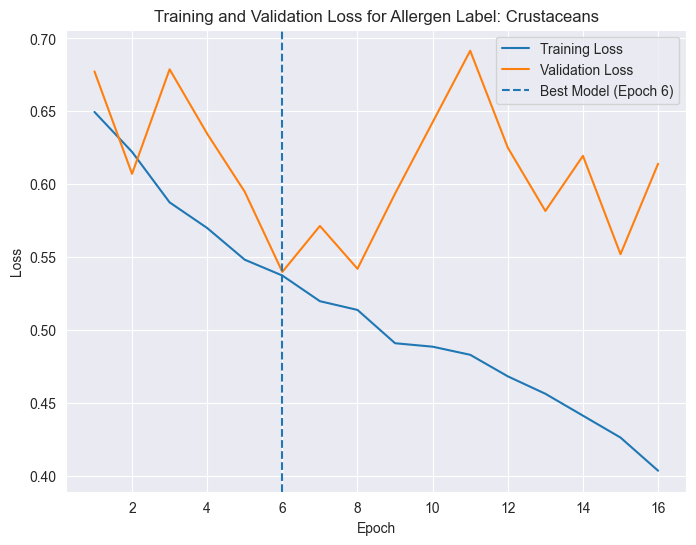

Test Error: 
 Accuracy: 72.05 % 




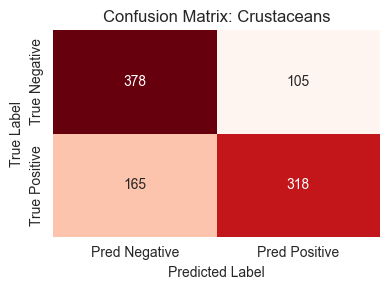



Classification Report:
              precision    recall  f1-score   support

         0.0       0.70      0.78      0.74       483
         1.0       0.75      0.66      0.70       483

    accuracy                           0.72       966
   macro avg       0.72      0.72      0.72       966
weighted avg       0.72      0.72      0.72       966



In [17]:
# trained with augments
hyperparameters = {
    'batch_size': 32,
    'learning_rate': 0.001,
    'epochs': 20,
    'patience': 10,
    'delta': 0.05,
    'prediction_threshold': 0.5
}
train_for_allergen_label(1, x, y, hyperparameters)

Before resampling: 2414 positives, 59608 negatives
After resampling: 2414 positives, 2414 negatives

Using cuda device

Epoch 1/10
Loss: 0.6884316 [    0/ 3862]
Loss: 0.6371784 [ 3200/ 3862]
Train loss for this epoch: 0.6397636
Validation loss for this epoch: 0.7448611
Saved new best model: Crustaceans.pt

Epoch 2/10
Loss: 0.5444476 [    0/ 3862]
Loss: 0.6503499 [ 3200/ 3862]
Train loss for this epoch: 0.6009559
Validation loss for this epoch: 1.3056135

Epoch 3/10
Loss: 0.6555128 [    0/ 3862]
Loss: 0.6115804 [ 3200/ 3862]
Train loss for this epoch: 0.5690737
Validation loss for this epoch: 0.6066171
Saved new best model: Crustaceans.pt

Epoch 4/10
Loss: 0.5903382 [    0/ 3862]
Loss: 0.6274805 [ 3200/ 3862]
Train loss for this epoch: 0.5463249
Validation loss for this epoch: 0.6312297

Epoch 5/10
Loss: 0.5343622 [    0/ 3862]
Loss: 0.5231863 [ 3200/ 3862]
Train loss for this epoch: 0.4839766
Validation loss for this epoch: 0.6138535

Epoch 6/10
Loss: 0.4400058 [    0/ 3862]
Loss: 0.55

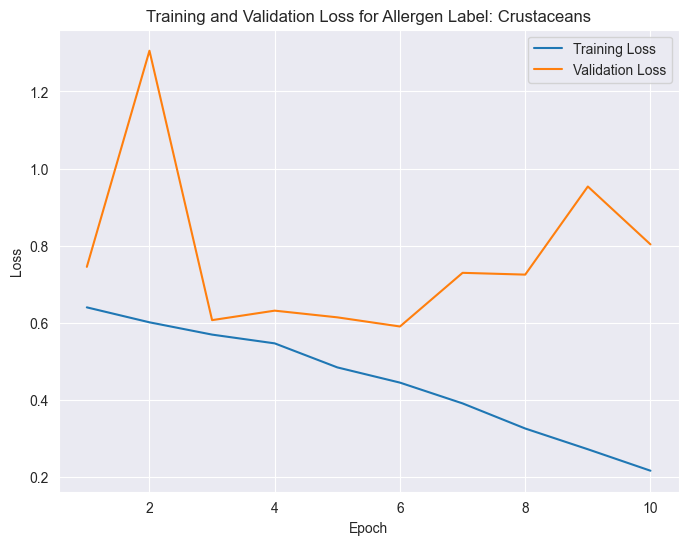

Test Error: 
 Accuracy: 69.25 % 




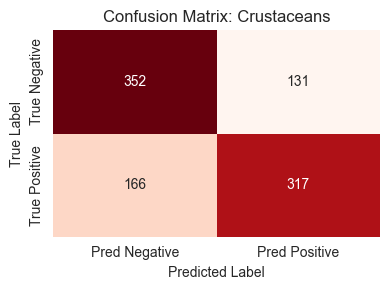



Classification Report:
              precision    recall  f1-score   support

         0.0       0.68      0.73      0.70       483
         1.0       0.71      0.66      0.68       483

    accuracy                           0.69       966
   macro avg       0.69      0.69      0.69       966
weighted avg       0.69      0.69      0.69       966



In [72]:
# trained without augments
hyperparameters = {
    'batch_size': 32,
    'learning_rate': 0.001,
    'epochs': 10,
    'patience': 10,
    'delta': 0.05,
    'prediction_threshold': 0.5
}
train_for_allergen_label(1, x, y, hyperparameters)

Before resampling: 2414 positives, 59608 negatives
After resampling: 2414 positives, 2414 negatives

Using cuda device

Epoch 1/100
Loss: 0.7005927 [    0/ 3379]
Train loss for this epoch: 0.6069912
Validation loss for this epoch: 0.7527682
Saved new best model: saved_models/Crustaceans/ResNet/BatchSize 64/LR 0.001/Crustaceans.pt

Epoch 2/100
Loss: 0.5687762 [    0/ 3379]
Train loss for this epoch: 0.5126196
Validation loss for this epoch: 0.5993793
Saved new best model: saved_models/Crustaceans/ResNet/BatchSize 64/LR 0.001/Crustaceans.pt

Epoch 3/100
Loss: 0.4632210 [    0/ 3379]
Train loss for this epoch: 0.4144542
Validation loss for this epoch: 0.6427137

Epoch 4/100
Loss: 0.3526241 [    0/ 3379]
Train loss for this epoch: 0.3337012
Validation loss for this epoch: 0.5835586
Saved new best model: saved_models/Crustaceans/ResNet/BatchSize 64/LR 0.001/Crustaceans.pt

Epoch 5/100
Loss: 0.2989906 [    0/ 3379]
Train loss for this epoch: 0.2675034
Validation loss for this epoch: 0.735151

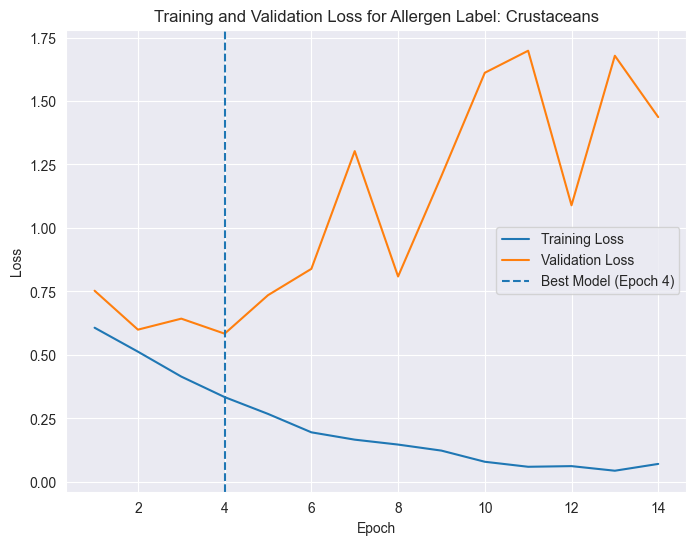

TEST RESULTS FOR BEST MODEL (lowest val loss):


Test Error: 
 Accuracy: 71.57 % 




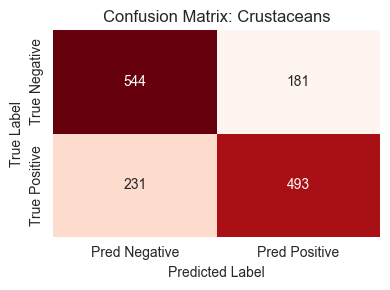



Classification Report:
              precision    recall  f1-score   support

         0.0       0.70      0.75      0.73       725
         1.0       0.73      0.68      0.71       724

    accuracy                           0.72      1449
   macro avg       0.72      0.72      0.72      1449
weighted avg       0.72      0.72      0.72      1449



In [37]:
#ResNet50
hyperparameters = {
    'batch_size': 64,
    'learning_rate': 0.001,
    'epochs': 100,
    'patience': 10,
    'delta': 0,
    'prediction_threshold': 0.5
}
train_for_allergen_label(1, x, y, hyperparameters)

Before resampling: 2414 positives, 59608 negatives
After resampling: 2414 positives, 2414 negatives

Using cuda device

Epoch 1/100
Loss: 0.6970050 [    0/ 3379]
Train loss for this epoch: 0.6939175
Validation loss for this epoch: 0.6934772
Saved new best model: saved_models/Crustaceans/Net/BatchSize 64/LR 0.001/Crustaceans.pt

Epoch 2/100
Loss: 0.6908135 [    0/ 3379]
Train loss for this epoch: 0.6880991
Validation loss for this epoch: 0.6979097

Epoch 3/100
Loss: 0.6668006 [    0/ 3379]
Train loss for this epoch: 0.6681157
Validation loss for this epoch: 0.6923004
Saved new best model: saved_models/Crustaceans/Net/BatchSize 64/LR 0.001/Crustaceans.pt

Epoch 4/100
Loss: 0.6003211 [    0/ 3379]
Train loss for this epoch: 0.5825297
Validation loss for this epoch: 0.8132744

Epoch 5/100
Loss: 0.4697132 [    0/ 3379]
Train loss for this epoch: 0.3561172
Validation loss for this epoch: 1.0298148

Epoch 6/100
Loss: 0.1448308 [    0/ 3379]
Train loss for this epoch: 0.1291175
Validation loss

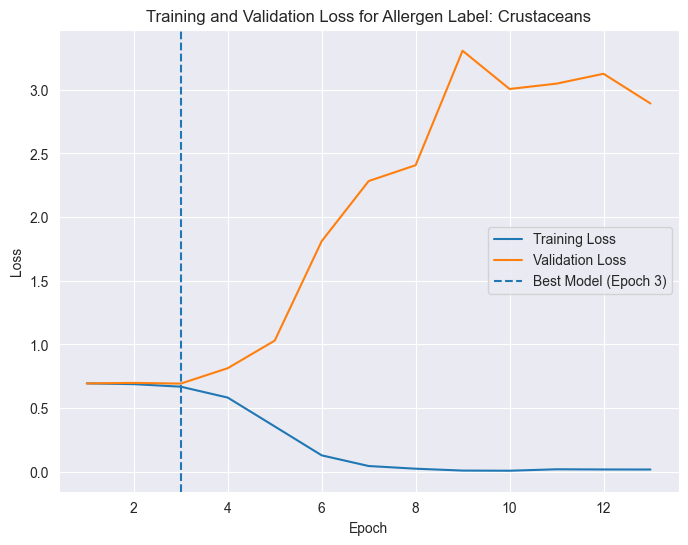

TEST RESULTS FOR BEST MODEL (lowest val loss):


Test Error: 
 Accuracy: 54.38 % 




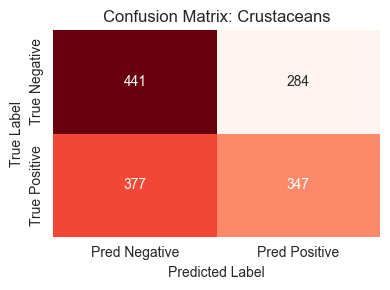



Classification Report:
              precision    recall  f1-score   support

         0.0       0.54      0.61      0.57       725
         1.0       0.55      0.48      0.51       724

    accuracy                           0.54      1449
   macro avg       0.54      0.54      0.54      1449
weighted avg       0.54      0.54      0.54      1449



In [35]:
#Custom CNN
hyperparameters = {
    'batch_size': 64,
    'learning_rate': 0.001,
    'epochs': 100,
    'patience': 10,
    'delta': 0,
    'prediction_threshold': 0.5
}
train_for_allergen_label(1, x, y, hyperparameters)